# Visualization Report

In [6]:
# load data from csv in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Set current directory containing data files
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/visualizations"

In [18]:
import os
print(os.listdir(DATA_DIR))

['performance_metrics.json', 'visualization.py', 'moderation_results.json', 'model_evaluation.png', 'deepseek']


In [19]:
"""
Improve the code below to generate visualization report using the data set DATA_DIR/performance_metrics.json and DATA_DIR/moderation_results.json

sample data from performance_metrics.json
{
  "accuracy": 0.7,
  "precision": 0.6538461538461539,
  "recall": 0.85,
  "f1": 0.7391304347826086,
  "confusion_matrix": [
    [
      11,
      9
    ],
    [
      3,
      17
    ]
  ],
  "roc_auc": 0.6887500000000001,
  "pr_auc": 0.7748846153846155,
  "avg_precision": 0.6196923076923077,
  "fpr": [
    0.0,
    0.45,
    0.45,
    1.0
  ],
  "tpr": [
    0.0,
    0.8,
    0.85,
    1.0
  ],
  "precision_curve": [
    0.5,
    0.6538461538461539,
    0.64,
    1.0
  ],
  "recall_curve": [
    1.0,
    0.85,
    0.8,
    0.0
  ],
  "sample_count": 40,
  "avg_latency": 11.015400367975236,
  "median_latency": 10.548894047737122,
  "std_latency": 1.7841024166840591,
  "min_latency": 6.471778869628906,
  "max_latency": 17.1921489238739,
  "accuracy_ci_lower": 0.575,
  "accuracy_ci_upper": 0.85,
  "classification_report": {
    "0": {
      "precision": 0.7857142857142857,
      "recall": 0.55,
      "f1-score": 0.6470588235294118,
      "support": 20.0
    },
    "1": {
      "precision": 0.6538461538461539,
      "recall": 0.85,
      "f1-score": 0.7391304347826086,
      "support": 20.0
    },
    "accuracy": 0.7,
    "macro avg": {
      "precision": 0.7197802197802198,
      "recall": 0.7,
      "f1-score": 0.6930946291560103,
      "support": 40.0
    },
    "weighted avg": {
      "precision": 0.7197802197802197,
      "recall": 0.7,
      "f1-score": 0.6930946291560102,
      "support": 40.0
    }
  }
}

sample data from moderation_results.json
[
  {
    "message": "You and others here are doing your best to convict Donald Trump of sexual assault via hearsay. When the shoe was on Bill Clinton's foot, the left did all they could to protect him and his hideous wife. So yes, you are well schooled in hypocrisy.\n\nOpenly boasting about groping women is a far cry from exploiting the power of the presidency to seduce interns, cover up rape and sexual assault. Allowing men with a psychological disorder to act out their fantasies by entering women's restrooms and insisting it's some sort of social justice issue is simply bizarre.\n\nIt appears to me that you have plenty of time to do your own research. Maybe you should broaden your search from Thinkprogess and Huffpo.\n\nSorry you missed the last one but at least you agree then that Hillary belongs in prison.",
    "ground_truth": "toxic",
    "prediction": "toxic",
    "confidence": 0.98,
    "latency": 3.4063611030578613,
    "message_length": 794,
    "categories": [],
    "reasoning": "The message contains derogatory language towards specific individuals and political parties, which can be considered toxic. It also includes accusations and name-calling.",
    "full_response": {
      "decision": "Toxic",
      "confidence": 0.98,
      "reasoning": "The message contains derogatory language towards specific individuals and political parties, which can be considered toxic. It also includes accusations and name-calling.",
      "processing_time_ms": 3357.271432876587,
      "template_version": "1.0"
    }
  },
  {
    "message": "Clinton says she \u201ckept my cool, aided by a lifetime of dealing with difficult men trying to throw me off.\u201d\nThe \"Most Difficult Man\", being her husband, the rapist.",
    "ground_truth": "toxic",
    "prediction": "toxic",
    "confidence": 0.98,
    "latency": 2.9411251544952393,
    "message_length": 163,
    "categories": [],
    "reasoning": "The message contains hate speech towards a specific individual, which is toxic and not allowed on the platform.",
    "full_response": {
      "decision": "Toxic",
      "confidence": 0.98,
      "reasoning": "The message contains hate speech towards a specific individual, which is toxic and not allowed on the platform.",
      "processing_time_ms": 2936.5944862365723,
      "template_version": "1.0"
    }
  }
  ]

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
import requests
import json
from datetime import datetime

def calculate_metrics(performance_metrics_path, moderation_results_path):
    """Calculates performance metrics from the provided data."""
    with open(performance_metrics_path, 'r') as f:
        performance_metrics = json.load(f)

    with open(moderation_results_path, 'r') as f:
        moderation_results = json.load(f)

    # Extract ground truth and predictions from moderation_results
    ground_truth = [item['ground_truth'] for item in moderation_results]
    predictions = [item['prediction'] for item in moderation_results]
    prediction_probabilities = [item.get('confidence', 0) for item in moderation_results] # Use .get to handle missing confidence

    # Calculate toxic-specific metrics
    toxic_ground_truth = [1 if gt == 'toxic' else 0 for gt in ground_truth]
    toxic_predictions = [1 if pred == 'toxic' else 0 for pred in predictions]

    toxic_precision = precision_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_recall = recall_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_f1 = f1_score(toxic_ground_truth, toxic_predictions, zero_division=0)

    # Get overall metrics from performance_metrics.json
    accuracy = performance_metrics.get('accuracy', 0)
    precision_weighted = performance_metrics.get('precision', 0) # Assuming 'precision' in json is weighted
    recall_weighted = performance_metrics.get('recall', 0) # Assuming 'recall' in json is weighted
    f1_weighted = performance_metrics.get('f1', 0) # Assuming 'f1' in json is weighted
    cm = performance_metrics.get('confusion_matrix', [[0,0],[0,0]])
    roc_auc = performance_metrics.get('roc_auc')
    accuracy_ci = (performance_metrics.get('accuracy_ci_lower', 0), performance_metrics.get('accuracy_ci_upper', 0))

    # Calculate confidence intervals for toxic metrics (simplified example, requires more data for proper calculation)
    # For a more robust calculation, you would need to perform bootstrapping or use statistical formulas
    toxic_precision_ci = (0, 0) # Placeholder
    toxic_recall_ci = (0, 0)   # Placeholder
    toxic_f1_ci = (0, 0)       # Placeholder


    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'toxic_precision': toxic_precision,
        'toxic_recall': toxic_recall,
        'toxic_f1': toxic_f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'sample_size': len(ground_truth),
        'accuracy_ci': accuracy_ci,
        'toxic_precision_ci': toxic_precision_ci,
        'toxic_recall_ci': toxic_recall_ci,
        'toxic_f1_ci': toxic_f1_ci,
        'ground_truth': ground_truth,
        'prediction_probabilities': prediction_probabilities,
        'processing_time': [item.get('latency') for item in moderation_results] # Use latency from moderation_results
    }
    return metrics


def create_evaluation_visualizations(metrics, output_dir):
    """Create comprehensive evaluation visualizations."""

    if not metrics:
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)


    # Create comprehensive evaluation figure
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrix
    ax1 = plt.subplot(3, 3, 1)
    cm = metrics['confusion_matrix']
    labels = sorted(list(set(metrics['ground_truth']))) # Use ground_truth from metrics

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # 2. Performance Metrics Bar Chart
    ax2 = plt.subplot(3, 3, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision_weighted'],
                    metrics['recall_weighted'], metrics['f1_weighted']]

    bars = ax2.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    ax2.set_ylim(0, 1)
    ax2.set_title('Overall Performance Metrics using Mistral 7B')
    ax2.set_ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 3. Toxic Detection Specific Metrics
    ax3 = plt.subplot(3, 3, 3)
    toxic_metrics = ['Precision', 'Recall', 'F1-Score']
    toxic_values = [metrics['toxic_precision'], metrics['toxic_recall'], metrics['toxic_f1']]

    bars = ax3.bar(toxic_metrics, toxic_values, color=['red', 'orange', 'darkred'], alpha=0.7)
    ax3.set_ylim(0, 1)
    ax3.set_title('Toxic Content Detection Metrics')
    ax3.set_ylabel('Score')

    for bar, value in zip(bars, toxic_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 4. ROC Curve (if available)
    if metrics['roc_auc'] is not None and len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        ax4 = plt.subplot(3, 3, 4)
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        fpr, tpr, _ = roc_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax4.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
        ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title('ROC Curve')
        ax4.legend(loc="lower right")
    else:
        ax4 = plt.subplot(3, 3, 4)
        ax4.text(0.5, 0.5, "ROC Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax4.axis('off')


    # 5. Precision-Recall Curve
    ax5 = plt.subplot(3, 3, 5)
    if len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics
        avg_precision = average_precision_score(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax5.plot(recall_curve, precision_curve, color='blue', lw=2,
                label=f'AP = {avg_precision:.3f}')
        ax5.set_xlabel('Recall')
        ax5.set_ylabel('Precision')
        ax5.set_title('Precision-Recall Curve')
        ax5.legend()
    else:
        ax5 = plt.subplot(3, 3, 5)
        ax5.text(0.5, 0.5, "Precision-Recall Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax5.axis('off')


    # 6. Confidence Distribution
    ax6 = plt.subplot(3, 3, 6)
    if metrics['prediction_probabilities']:
        ax6.hist(metrics['prediction_probabilities'], bins=20, alpha=0.7, color='skyblue', edgecolor='black') # Use prediction_probabilities from metrics
        ax6.set_xlabel('Prediction Confidence')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Prediction Confidence Distribution')
        ax6.axvline(np.mean(metrics['prediction_probabilities']), color='red', linestyle='--', # Use prediction_probabilities from metrics
                   label=f'Mean: {np.mean(metrics["prediction_probabilities"]):.3f}')
        ax6.legend()
    else:
        ax6 = plt.subplot(3, 3, 6)
        ax6.text(0.5, 0.5, "Confidence Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax6.axis('off')


    # 7. Processing Time Analysis
    ax7 = plt.subplot(3, 3, 7)
    processing_times = [t for t in metrics['processing_time'] if t is not None] # Use processing_time from metrics and filter None values
    if processing_times:
        ax7.hist(processing_times, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        ax7.set_xlabel('Processing Time (ms)')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Processing Time Distribution')
        ax7.axvline(np.mean(processing_times), color='red', linestyle='--',
                   label=f'Mean: {np.mean(processing_times):.1f}ms')
        ax7.legend()
    else:
        ax7 = plt.subplot(3, 3, 7)
        ax7.text(0.5, 0.5, "Processing Time Data Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax7.axis('off')

    # 8. Performance Summary Table
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('tight')
    ax8.axis('off')

    summary_data = [
        ['Metric', 'Value', '95% CI'],
        ['Accuracy', f'{metrics["accuracy"]:.3f}',
         f'({metrics.get("accuracy_ci", (0,0))[0]:.3f}, {metrics.get("accuracy_ci", (0,0))[1]:.3f})'],
        ['Toxic Precision', f'{metrics["toxic_precision"]:.3f}',
         f'({metrics.get("toxic_precision_ci", (0,0))[0]:.3f}, {metrics.get("toxic_precision_ci", (0,0))[1]:.3f})'],
        ['Toxic Recall', f'{metrics["toxic_recall"]:.3f}',
         f'({metrics.get("toxic_recall_ci", (0,0))[0]:.3f}, {metrics.get("toxic_recall_ci", (0,0))[1]:.3f})'],
        ['Toxic F1-Score', f'{metrics["toxic_f1"]:.3f}',
         f'({metrics.get("toxic_f1_ci", (0,0))[0]:.3f}, {metrics.get("toxic_f1_ci", (0,0))[1]:.3f})'],
        ['Sample Size', f'{metrics["sample_size"]}', 'N/A']
    ]

    table = ax8.table(cellText=summary_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax8.set_title('Performance Summary with Confidence Intervals')

    # 9. Label Distribution
    ax9 = plt.subplot(3, 3, 9)
    if metrics['ground_truth']:
        label_counts = pd.Series(metrics['ground_truth']).value_counts() # Use ground_truth from metrics
        ax9.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        ax9.set_title('Ground Truth Label Distribution')
    else:
        ax9 = plt.subplot(3, 3, 9)
        ax9.text(0.5, 0.5, "Label Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax9.axis('off')


    plt.tight_layout()
    plt.savefig(f'{output_dir}/model_evaluation-mistral-7b.png', dpi=300, bbox_inches='tight')
    plt.close()

    return metrics

# generate report
if __name__ == "__main__":
    performance_metrics_path = os.path.join(DATA_DIR, 'performance_metrics.json')
    moderation_results_path = os.path.join(DATA_DIR, 'moderation_results.json')

    # Calculate metrics
    evaluation_metrics = calculate_metrics(performance_metrics_path, moderation_results_path)

    # Create visualizations
    create_evaluation_visualizations(evaluation_metrics, DATA_DIR)

    print("Report generated successfully for mistral 7b.")

Report generated successfully.


In [7]:
# Set current directory containing data files
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/visualizations/deepseek"

In [8]:
import os
print(os.listdir(DATA_DIR))

['performance_metrics.json', 'moderation_results.json', 'model_evaluation.png', 'model_evaluation-deepseek-r1.png']


In [22]:
"""

Generate report

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import stats
import requests
import json
from datetime import datetime

def calculate_metrics(performance_metrics_path, moderation_results_path):
    """Calculates performance metrics from the provided data."""
    with open(performance_metrics_path, 'r') as f:
        performance_metrics = json.load(f)

    with open(moderation_results_path, 'r') as f:
        moderation_results = json.load(f)

    # Extract ground truth and predictions from moderation_results
    ground_truth = [item['ground_truth'] for item in moderation_results]
    predictions = [item['prediction'] for item in moderation_results]
    prediction_probabilities = [item.get('confidence', 0) for item in moderation_results] # Use .get to handle missing confidence

    # Calculate toxic-specific metrics
    toxic_ground_truth = [1 if gt == 'toxic' else 0 for gt in ground_truth]
    toxic_predictions = [1 if pred == 'toxic' else 0 for pred in predictions]

    toxic_precision = precision_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_recall = recall_score(toxic_ground_truth, toxic_predictions, zero_division=0)
    toxic_f1 = f1_score(toxic_ground_truth, toxic_predictions, zero_division=0)

    # Get overall metrics from performance_metrics.json
    accuracy = performance_metrics.get('accuracy', 0)
    precision_weighted = performance_metrics.get('precision', 0) # Assuming 'precision' in json is weighted
    recall_weighted = performance_metrics.get('recall', 0) # Assuming 'recall' in json is weighted
    f1_weighted = performance_metrics.get('f1', 0) # Assuming 'f1' in json is weighted
    cm = performance_metrics.get('confusion_matrix', [[0,0],[0,0]])
    roc_auc = performance_metrics.get('roc_auc')
    accuracy_ci = (performance_metrics.get('accuracy_ci_lower', 0), performance_metrics.get('accuracy_ci_upper', 0))

    # Calculate confidence intervals for toxic metrics (simplified example, requires more data for proper calculation)
    # For a more robust calculation, you would need to perform bootstrapping or use statistical formulas
    toxic_precision_ci = (0, 0) # Placeholder
    toxic_recall_ci = (0, 0)   # Placeholder
    toxic_f1_ci = (0, 0)       # Placeholder


    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'toxic_precision': toxic_precision,
        'toxic_recall': toxic_recall,
        'toxic_f1': toxic_f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'sample_size': len(ground_truth),
        'accuracy_ci': accuracy_ci,
        'toxic_precision_ci': toxic_precision_ci,
        'toxic_recall_ci': toxic_recall_ci,
        'toxic_f1_ci': toxic_f1_ci,
        'ground_truth': ground_truth,
        'prediction_probabilities': prediction_probabilities,
        'processing_time': [item.get('latency') for item in moderation_results] # Use latency from moderation_results
    }
    return metrics


def create_evaluation_visualizations(metrics, output_dir):
    """Create comprehensive evaluation visualizations."""

    if not metrics:
        return

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)


    # Create comprehensive evaluation figure
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrix
    ax1 = plt.subplot(3, 3, 1)
    cm = metrics['confusion_matrix']
    labels = sorted(list(set(metrics['ground_truth']))) # Use ground_truth from metrics

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels, yticklabels=labels, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # 2. Performance Metrics Bar Chart
    ax2 = plt.subplot(3, 3, 2)
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision_weighted'],
                    metrics['recall_weighted'], metrics['f1_weighted']]

    bars = ax2.bar(metric_names, metric_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    ax2.set_ylim(0, 1)
    ax2.set_title('Overall Performance Metrics using DeepSeek-R1')
    ax2.set_ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 3. Toxic Detection Specific Metrics
    ax3 = plt.subplot(3, 3, 3)
    toxic_metrics = ['Precision', 'Recall', 'F1-Score']
    toxic_values = [metrics['toxic_precision'], metrics['toxic_recall'], metrics['toxic_f1']]

    bars = ax3.bar(toxic_metrics, toxic_values, color=['red', 'orange', 'darkred'], alpha=0.7)
    ax3.set_ylim(0, 1)
    ax3.set_title('Toxic Content Detection Metrics')
    ax3.set_ylabel('Score')

    for bar, value in zip(bars, toxic_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    # 4. ROC Curve (if available)
    if metrics['roc_auc'] is not None and len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        ax4 = plt.subplot(3, 3, 4)
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        fpr, tpr, _ = roc_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax4.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
        ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax4.set_xlim([0.0, 1.0])
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('False Positive Rate')
        ax4.set_ylabel('True Positive Rate')
        ax4.set_title('ROC Curve')
        ax4.legend(loc="lower right")
    else:
        ax4 = plt.subplot(3, 3, 4)
        ax4.text(0.5, 0.5, "ROC Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax4.axis('off')


    # 5. Precision-Recall Curve
    ax5 = plt.subplot(3, 3, 5)
    if len(set([1 if label == "toxic" else 0 for label in metrics['ground_truth']])) > 1: # Use ground_truth from metrics
        y_true_binary = [1 if label == "toxic" else 0 for label in metrics['ground_truth']] # Use ground_truth from metrics
        precision_curve, recall_curve, _ = precision_recall_curve(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics
        avg_precision = average_precision_score(y_true_binary, metrics['prediction_probabilities']) # Use prediction_probabilities from metrics

        ax5.plot(recall_curve, precision_curve, color='blue', lw=2,
                label=f'AP = {avg_precision:.3f}')
        ax5.set_xlabel('Recall')
        ax5.set_ylabel('Precision')
        ax5.set_title('Precision-Recall Curve')
        ax5.legend()
    else:
        ax5 = plt.subplot(3, 3, 5)
        ax5.text(0.5, 0.5, "Precision-Recall Curve Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax5.axis('off')


    # 6. Confidence Distribution
    ax6 = plt.subplot(3, 3, 6)
    if metrics['prediction_probabilities']:
        ax6.hist(metrics['prediction_probabilities'], bins=20, alpha=0.7, color='skyblue', edgecolor='black') # Use prediction_probabilities from metrics
        ax6.set_xlabel('Prediction Confidence')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Prediction Confidence Distribution')
        ax6.axvline(np.mean(metrics['prediction_probabilities']), color='red', linestyle='--', # Use prediction_probabilities from metrics
                   label=f'Mean: {np.mean(metrics["prediction_probabilities"]):.3f}')
        ax6.legend()
    else:
        ax6 = plt.subplot(3, 3, 6)
        ax6.text(0.5, 0.5, "Confidence Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax6.axis('off')


    # 7. Processing Time Analysis
    ax7 = plt.subplot(3, 3, 7)
    processing_times = [t for t in metrics['processing_time'] if t is not None] # Use processing_time from metrics and filter None values
    if processing_times:
        ax7.hist(processing_times, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        ax7.set_xlabel('Processing Time (ms)')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Processing Time Distribution')
        ax7.axvline(np.mean(processing_times), color='red', linestyle='--',
                   label=f'Mean: {np.mean(processing_times):.1f}ms')
        ax7.legend()
    else:
        ax7 = plt.subplot(3, 3, 7)
        ax7.text(0.5, 0.5, "Processing Time Data Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax7.axis('off')

    # 8. Performance Summary Table
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('tight')
    ax8.axis('off')

    summary_data = [
        ['Metric', 'Value', '95% CI'],
        ['Accuracy', f'{metrics["accuracy"]:.3f}',
         f'({metrics.get("accuracy_ci", (0,0))[0]:.3f}, {metrics.get("accuracy_ci", (0,0))[1]:.3f})'],
        ['Toxic Precision', f'{metrics["toxic_precision"]:.3f}',
         f'({metrics.get("toxic_precision_ci", (0,0))[0]:.3f}, {metrics.get("toxic_precision_ci", (0,0))[1]:.3f})'],
        ['Toxic Recall', f'{metrics["toxic_recall"]:.3f}',
         f'({metrics.get("toxic_recall_ci", (0,0))[0]:.3f}, {metrics.get("toxic_recall_ci", (0,0))[1]:.3f})'],
        ['Toxic F1-Score', f'{metrics["toxic_f1"]:.3f}',
         f'({metrics.get("toxic_f1_ci", (0,0))[0]:.3f}, {metrics.get("toxic_f1_ci", (0,0))[1]:.3f})'],
        ['Sample Size', f'{metrics["sample_size"]}', 'N/A']
    ]

    table = ax8.table(cellText=summary_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax8.set_title('Performance Summary with Confidence Intervals')

    # 9. Label Distribution
    ax9 = plt.subplot(3, 3, 9)
    if metrics['ground_truth']:
        label_counts = pd.Series(metrics['ground_truth']).value_counts() # Use ground_truth from metrics
        ax9.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
        ax9.set_title('Ground Truth Label Distribution')
    else:
        ax9 = plt.subplot(3, 3, 9)
        ax9.text(0.5, 0.5, "Label Distribution Not Available", horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax9.axis('off')


    plt.tight_layout()
    plt.savefig(f'{output_dir}/model_evaluation-deepseek-r1.png', dpi=300, bbox_inches='tight')
    plt.close()

    return metrics

# generate report
if __name__ == "__main__":
    performance_metrics_path = os.path.join(DATA_DIR, 'performance_metrics.json')
    moderation_results_path = os.path.join(DATA_DIR, 'moderation_results.json')

    # Calculate metrics
    evaluation_metrics = calculate_metrics(performance_metrics_path, moderation_results_path)

    # Create visualizations
    create_evaluation_visualizations(evaluation_metrics, DATA_DIR)

    print("Report generated successfully for DeepSeek LLM.")

Report generated successfully for DeepSeek LLM.


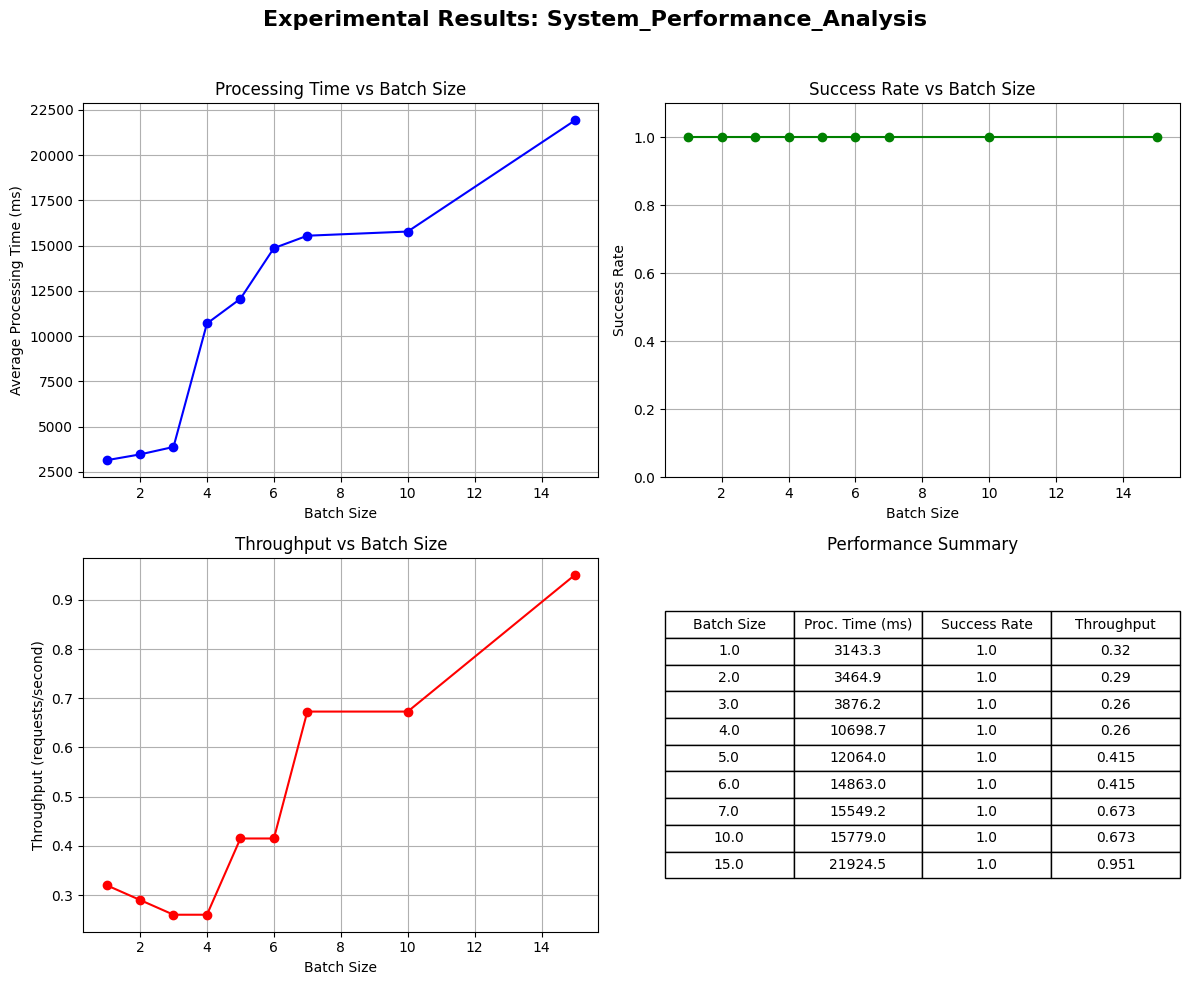

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Batch Size': [1, 2, 3, 4, 5, 6, 7, 10, 15],
    'Proc. Time (ms)': [3143.3, 3464.9, 3876.2, 10698.7, 12064.0, 14863.0, 15549.2, 15779.0, 21924.5],
    'Success Rate': [1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
    'Throughput': [0.32, 0.29, 0.26, 0.26, 0.415, 0.415, 0.673, 0.673, 0.951]
}

df = pd.DataFrame(data)

# Create figure and subplots
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Experimental Results: System_Performance_Analysis', fontsize=16, fontweight='bold')

# Plot 1: Processing Time vs Batch Size
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(df['Batch Size'], df['Proc. Time (ms)'], marker='o', color='blue')
ax1.set_title('Processing Time vs Batch Size')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Average Processing Time (ms)')
ax1.grid(True)

# Plot 2: Success Rate vs Batch Size
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(df['Batch Size'], df['Success Rate'], marker='o', color='green')
ax2.set_title('Success Rate vs Batch Size')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Success Rate')
ax2.set_ylim(0, 1.1)
ax2.grid(True)

# Plot 3: Throughput vs Batch Size
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax3.plot(df['Batch Size'], df['Throughput'], marker='o', color='red')
ax3.set_title('Throughput vs Batch Size')
ax3.set_xlabel('Batch Size')
ax3.set_ylabel('Throughput (requests/second)')
ax3.grid(True)

# Table
ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.axis('off')
table = ax4.table(
    cellText=df.values,
    colLabels=df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
ax4.set_title('Performance Summary')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save or show
plt.savefig('System_Performance_Analysis_Report.png', dpi=300)
plt.savefig(f'{DATA_DIR}/model_evaluation-deepseek-r1.png', dpi=300, bbox_inches='tight')
plt.show()
